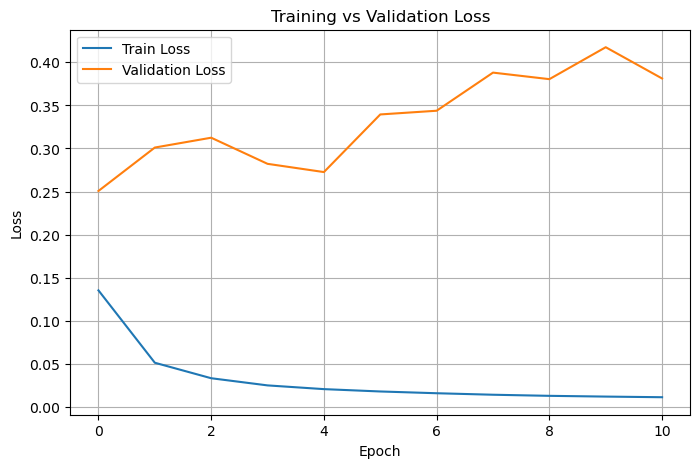

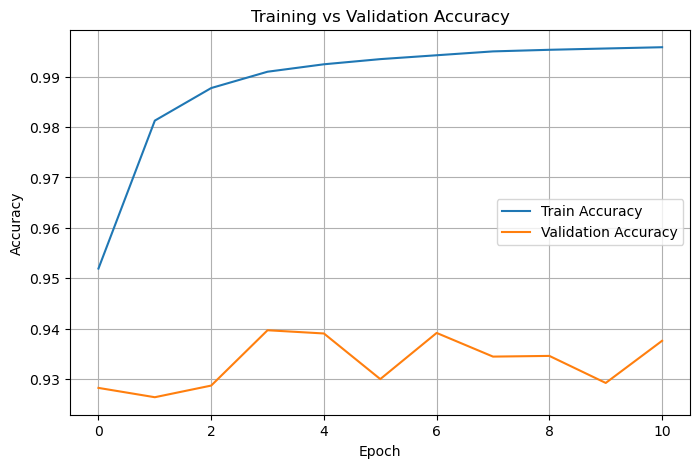

In [1]:
import pickle
import matplotlib.pyplot as plt

# Load training history
with open("./3dcnn_convlstm2d_Wmodels/2cams/training_history-patience5.pkl", "rb") as f:
    history = pickle.load(f)

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import Counter

# =======================
# Reproducibility (match training)
# =======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# =======================
# Paths & constants (same as training)
# =======================
FRAMES_ROOTS = ["./cam2-resized_frames", "./cam3-resized_frames"]
LABELS_ROOT = "./micro_activity_output"
SEQUENCE_LENGTH = 16
MODEL_PATH = "./3dcnn_convlstm2d_Wmodels/2cams/fall_3dcnn_convlstm2d_final-patience5.pth"

# =======================
# Load prepared sequence list (same pickle as training)
# =======================
with open("./f_seq_r_3dcnn-convlstm2d-2cams.pkl", "rb") as f:
    dataset = pickle.load(f)
print(f"Loaded dataset with {len(dataset)} sequences.")

# =======================
# Deterministic actor-based split (same logic as training)
# =======================
actor_to_samples = {}
for seq_paths, label in dataset:
    parts = seq_paths[0].split(os.sep)
    actor_folder = next(p for p in parts if p.startswith("Actor_"))
    actor_id = "_".join(actor_folder.split("_")[:2])  # e.g., Actor_1
    actor_to_samples.setdefault(actor_id, []).append((seq_paths, label))

all_actors = sorted(actor_to_samples.keys())
rng = random.Random(SEED)
rng.shuffle(all_actors)

split_idx = int(0.8 * len(all_actors))
train_actors, val_actors = all_actors[:split_idx], all_actors[split_idx:]

train_samples = [s for a in train_actors for s in actor_to_samples[a]]
val_samples   = [s for a in val_actors   for s in actor_to_samples[a]]

print("VAL actors:", val_actors)
print("TRAIN actors:", train_actors)
print("VAL class dist:", Counter([y for _, y in val_samples]))
print("TRAIN class dist:", Counter([y for _, y in train_samples]))
print(f"Actors: {len(all_actors)}, Train actors: {len(train_actors)}, Val actors: {len(val_actors)}")
print(f"Train sequences: {len(train_samples)}, Val sequences: {len(val_samples)}")

# =======================
# Dataset definition (same transforms as training)
# =======================
class FallSequenceDataset(Dataset):
    def __init__(self, sequence_label_list, transform=None):
        self.data = sequence_label_list
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),  # keep identical to training
        ])
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        frame_paths, label = self.data[idx]
        frames = []
        for path in frame_paths:
            img = Image.open(path).convert("RGB")
            img = self.transform(img)
            frames.append(img)
        frames_tensor = torch.stack(frames).permute(1,0,2,3)  # [C,T,H,W]
        return frames_tensor, torch.tensor(label, dtype=torch.long)

val_dataset = FallSequenceDataset(val_samples)
val_loader  = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# =======================
# Model (must match training architecture)
# =======================
from convlstm import ConvLSTM

class FallDetector3D(nn.Module):
    def __init__(self, num_classes=3):
        super(FallDetector3D, self).__init__()
        self.conv3d = nn.Sequential(
            nn.Conv3d(3, 96, kernel_size=(3,3,3), stride=1, padding=1),
            nn.BatchNorm3d(96),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2)),
            nn.Conv3d(96, 192, kernel_size=(3,3,3), stride=1, padding=1),
            nn.BatchNorm3d(192),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2)),
            nn.Conv3d(192, 384, kernel_size=(3,3,3), stride=1, padding=1),
            nn.BatchNorm3d(384),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2))
        )
        self.convlstm = ConvLSTM(input_dim=384, hidden_dim=384,
                                 kernel_size=(3,3), num_layers=2,
                                 batch_first=True, bias=True,
                                 return_all_layers=False)
        self.pool = nn.AdaptiveAvgPool2d((7,7))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(384*7*7, num_classes)

    def forward(self, x):
        feat3d = self.conv3d(x)               # [B,384,T,H,W]
        B, C, T, H, W = feat3d.shape
        feat3d = feat3d.permute(0,2,1,3,4)    # [B,T,C,H,W]
        out, _ = self.convlstm(feat3d)
        last_out = out[0][:,-1]               # [B,C,H,W]
        pooled = self.pool(last_out)          # [B,C,7,7]
        flat = pooled.view(B, -1)
        flat = self.dropout(flat)
        return self.fc(flat)


Loaded dataset with 702093 sequences.
VAL actors: ['Actor_1', 'Actor_2']
TRAIN actors: ['Actor_4', 'Actor_5', 'Actor_7', 'Actor_8', 'Actor_3', 'Actor_6']
VAL class dist: Counter({0: 197466, 2: 20336, 1: 16348})
TRAIN class dist: Counter({0: 394148, 2: 46230, 1: 27565})
Actors: 8, Train actors: 6, Val actors: 2
Train sequences: 467943, Val sequences: 234150


In [3]:
#load model
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

model = FallDetector3D(num_classes=3).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


FallDetector3D(
  (conv3d): Sequential(
    (0): Conv3d(3, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv3d(96, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(192, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): BatchNorm3d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0-1): 2 x ConvLSTMCell(

In [4]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 23791299
Trainable parameters: 23791299


In [5]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch

# same transforms used during training
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # only if you trained with 224x224
    transforms.ToTensor()
])

class_names = ["ADL", "Fall", "Lie Down"]

def predict_sequence(frame_paths):
    frames = []
    for path in frame_paths:
        img = Image.open(path).convert("RGB")
        img = transform(img)
        frames.append(img)

    # convert to [1,C,T,H,W] for 3D CNN
    frames_tensor = torch.stack(frames)  # [T,C,H,W]
    frames_tensor = frames_tensor.permute(1,0,2,3).unsqueeze(0).to(device)  # [1,C,T,H,W]

    with torch.no_grad():
        outputs = model(frames_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    print(f"Predicted class: {predicted_class}")

    # show 16 frames
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        frame = frames[i].permute(1, 2, 0).numpy()  # [C,H,W] -> [H,W,C]
        ax.imshow(frame)
        ax.axis("off")
    plt.suptitle(f"Predicted: {predicted_class}", fontsize=16)
    plt.tight_layout()
    plt.show()

Number of Fall samples in val: 16348
showing a TP Fall at index: 975
Predicted class: Fall


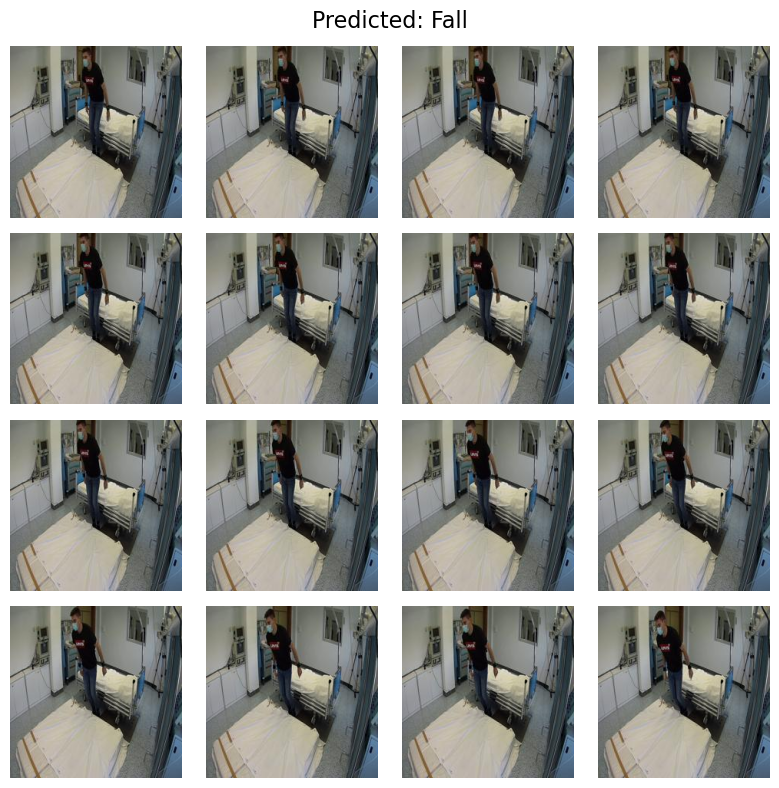

In [12]:
# collect indices of FALL samples in validation set (label == 1)
fall_indices = [i for i, (_, lab) in enumerate(val_samples) if lab == 1]
print("Number of Fall samples in val:", len(fall_indices))


def predict_label(frame_paths):
    frames = [transform(Image.open(p).convert("RGB")) for p in frame_paths]
    x = torch.stack(frames).permute(1,0,2,3).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        return out.argmax(dim=1).item()

# search a FALL sample that the model predicts as FALL (TP)
tp_idx = None
for i in fall_indices:
    pred = predict_label(val_samples[i][0])
    if pred == 1:  # 1 = Fall
        tp_idx = i
        break

if tp_idx is not None:
    print("showing a TP Fall at index:", tp_idx)
    predict_sequence(val_samples[tp_idx][0])
else:
    print("No Fall predicted as Fall found in the searched subset.")


Predicted class: Fall


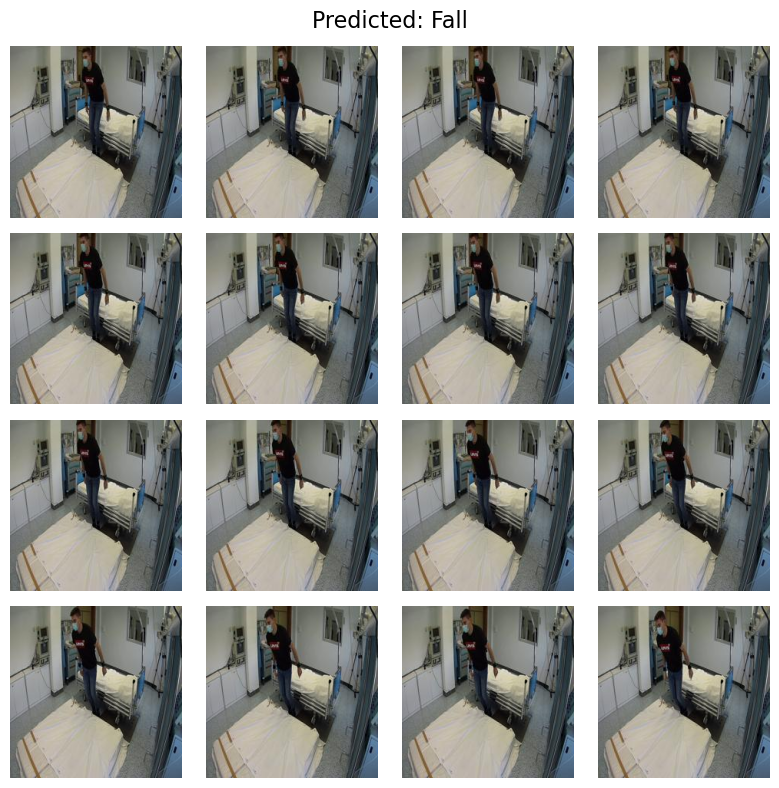

In [13]:
sample_seq = val_samples[975][0]
predict_sequence(sample_seq)

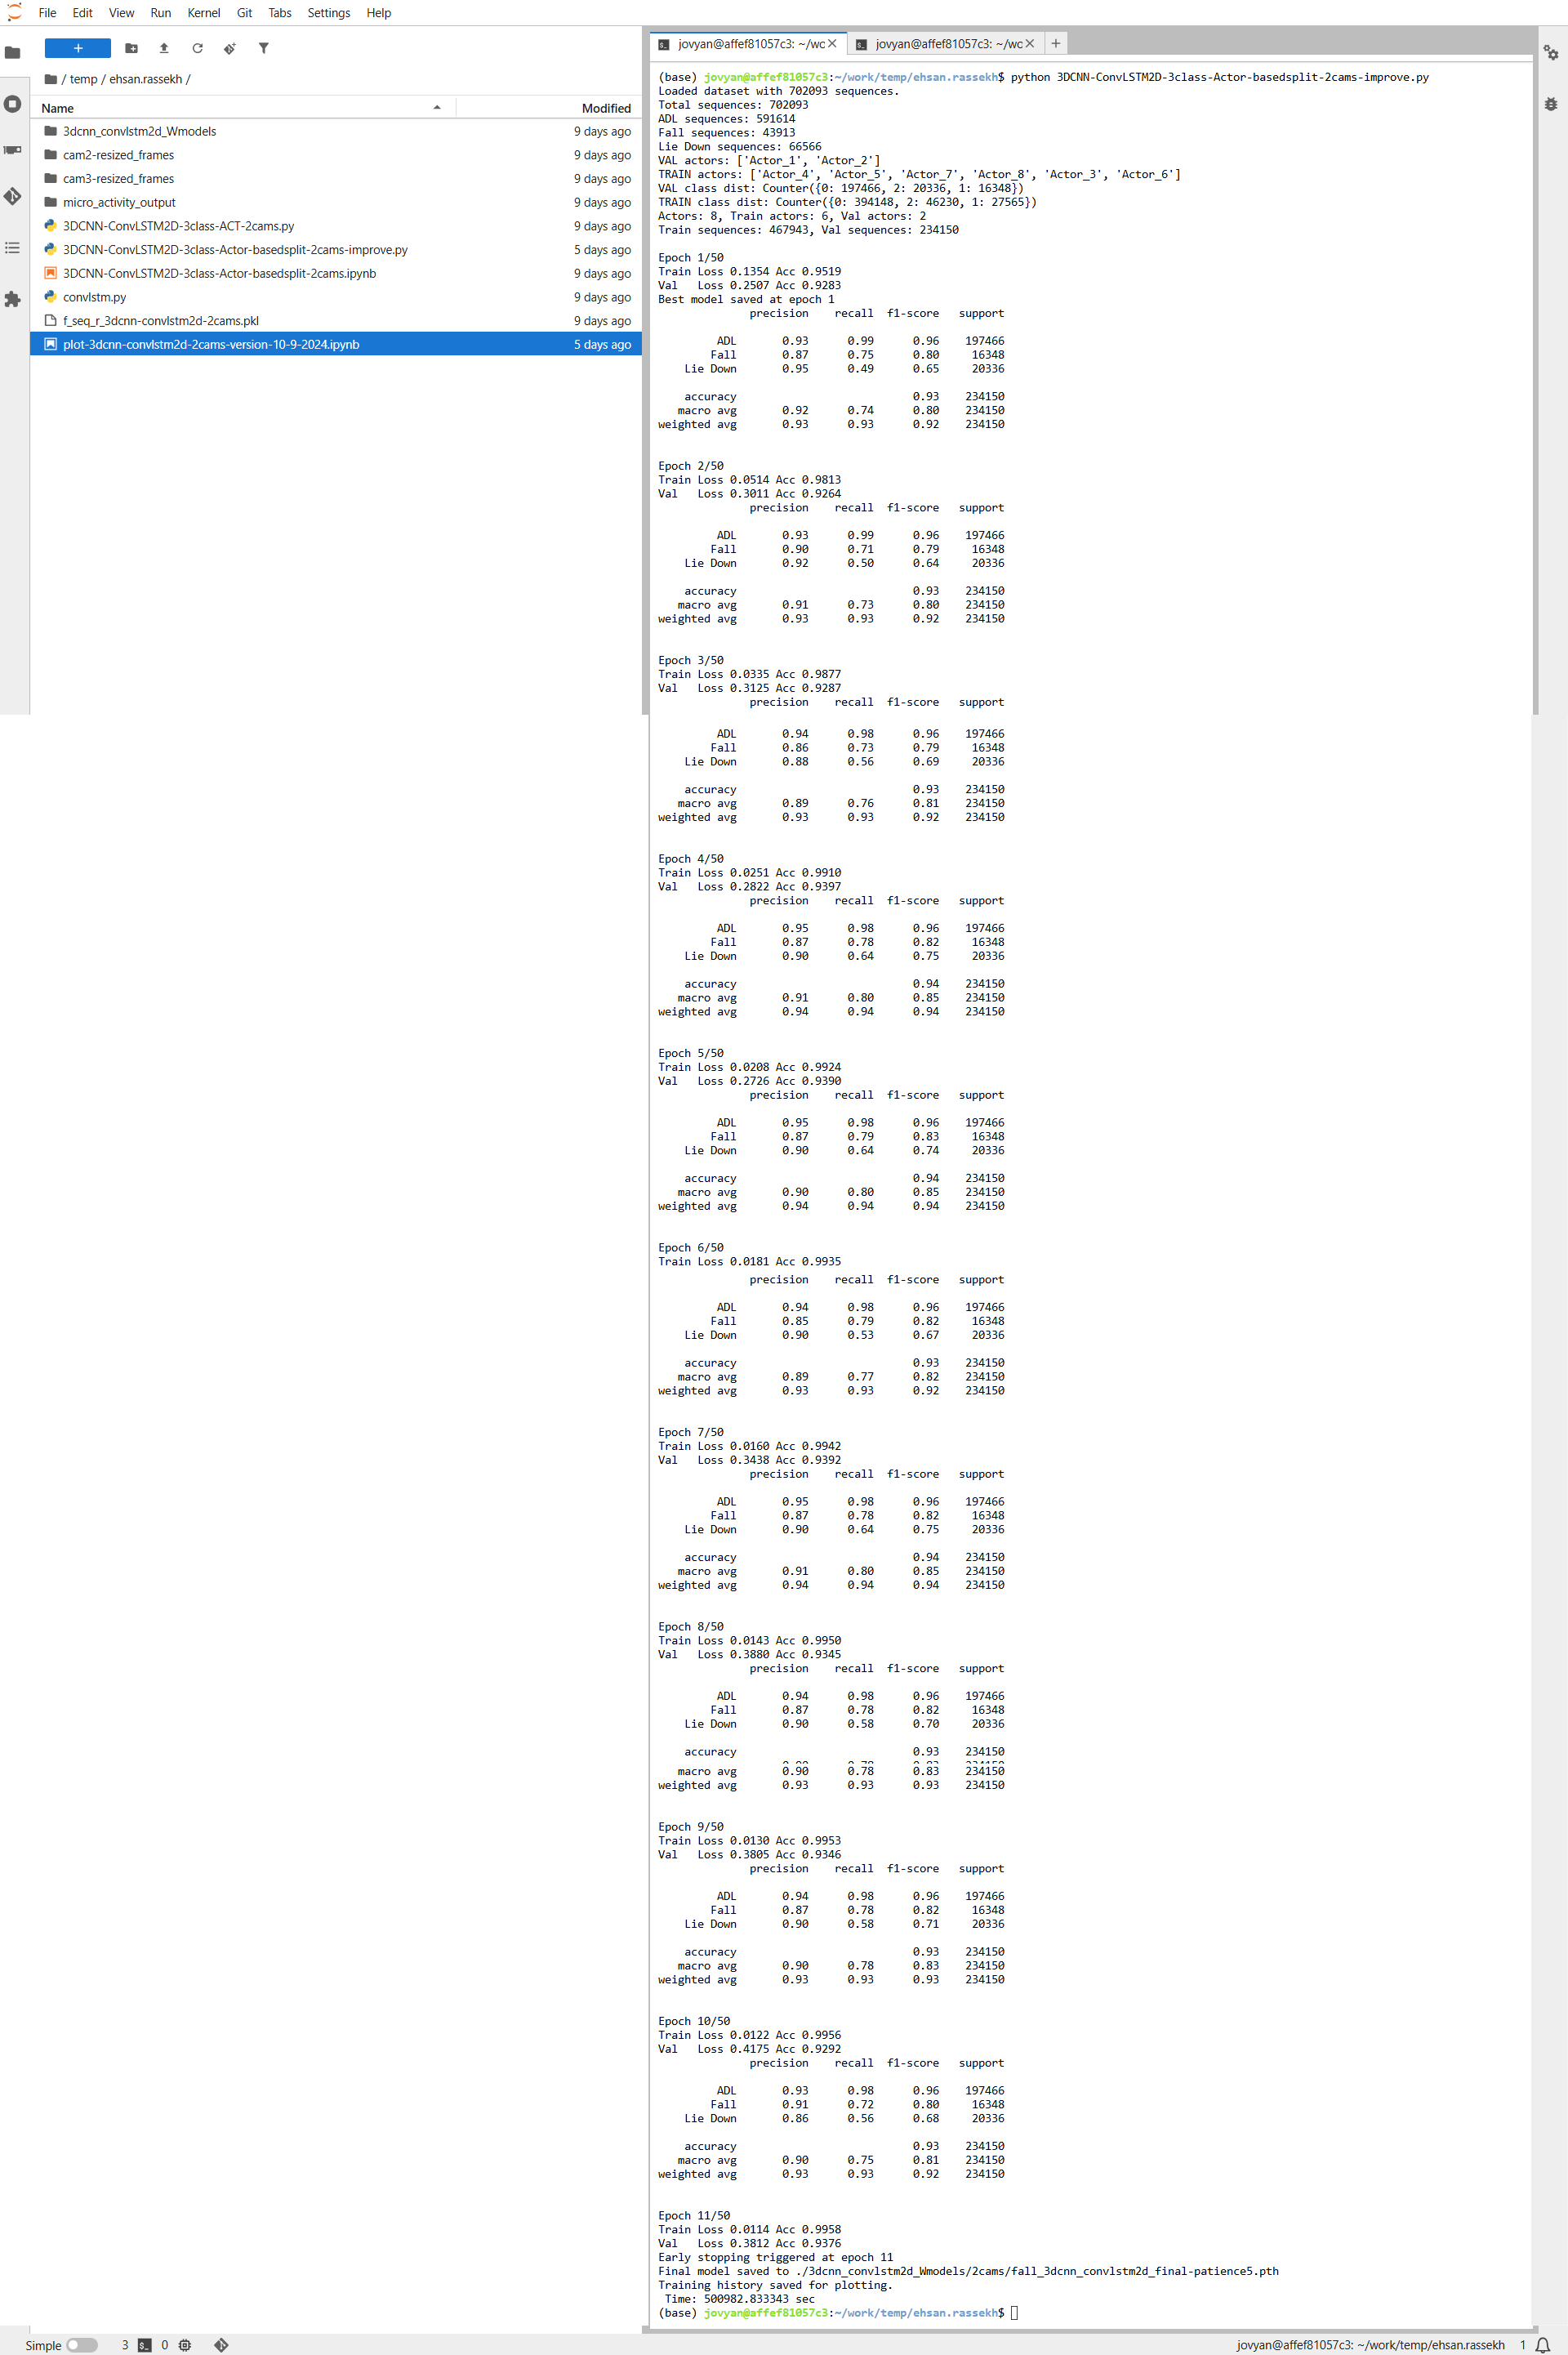

It took about 6 days (around 141.6 hours) of training time.

Validation Accuracy (Best Model): 0.9376

Classification Report:
               precision    recall  f1-score   support

         ADL       0.94      0.99      0.96    197466
        Fall       0.88      0.78      0.83     16348
    Lie Down       0.91      0.60      0.72     20336

    accuracy                           0.94    234150
   macro avg       0.91      0.79      0.84    234150
weighted avg       0.94      0.94      0.93    234150



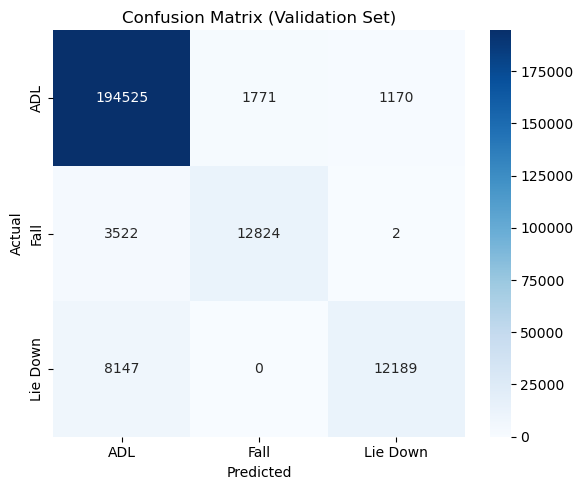

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# total Accuracy
print(f"Validation Accuracy (Best Model): {correct / total:.4f}")

# Classification Report
class_names = ["ADL", "Fall", "Lie Down"]
report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
print("\nClassification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()